# Measurement 2020-02-03 Neutron Output vs Beam Power

Files in /Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower

In [21]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

In [22]:
def load_data_for_day_CSV(DAY, PATH):
    data_dose = pd.read_csv(f'{PATH}/{DAY}_dose.csv', index_col=0)
    data_hv = pd.read_csv(f'{PATH}/{DAY}_hv.csv', index_col=0)
    data_pressure = pd.read_csv(f'{PATH}/{DAY}_pressure.csv', index_col=0)
    data_microwave_power_full = pd.read_csv(f'{PATH}/{DAY}_microwave_power.csv', index_col=0)
    data_microwave_frequency_full = pd.read_csv(f'{PATH}/{DAY}_microwave_frequency.csv', index_col=0)

    for df in [data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full]:
        df.index = pd.to_datetime(df.index)
        
        
    return data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full

In [23]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out


In [24]:
DAY = "2020-02-03"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/'

In [25]:
data_dose, data_hv, data_pressure, data_microwave_power_full, data_microwave_frequency_full = load_data_for_day_CSV(DAY, PATH)

In [26]:
time_start = f"{DAY} 08:29:00"
time_end = f"{DAY} 11:00:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]
data_microwave_power_full = data_microwave_power_full.loc[time_start:time_end, :]
data_microwave_frequency_full = data_microwave_frequency_full.loc[time_start:time_end, :]


### Find different levels in the high voltage

In [27]:
data_hv['time_delta_minutes'] = data_hv.index
data_hv['time_delta_minutes'] = data_hv['time_delta_minutes'].apply(lambda x: (x - data_hv.index[0]).seconds/60)

In [28]:
times = pd.read_excel('/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/2020-02-03.NeutronOutputVSBeamPower.xlsx', 'Sheet2', header=None)
times.columns = ['t0', 't1']

for col in times.columns:    
    new_col = [f"{DAY} {f}" for f in times[col].astype(str)]  
    times[col] = pd.to_datetime(new_col) 

times['t0'] = times['t0'] + pd.Timedelta('10S')
times['t1'] = times['t1'] - pd.Timedelta('10S')
times['tdiff'] = (times['t1'] - times['t0']).dt.seconds
times = times.loc[~(times['tdiff'] > 800) & ~(times['tdiff'] < 10)]

In [29]:
HV_m = data_hv[['HV_voltage', 'HV_current', 'time_delta_minutes']]
def get_average_hv_current(row, HV_m):
    t0 = row['t0']
    t1 = row['t1']
    
    hv = HV_m.loc[t0:t1, ['HV_voltage', 'HV_current']]
#     plt.hist(hv['HV_voltage'], bins=20, density=True)
#     plt.show()
#     print(t0)

    m = np.mean(hv)
    m.index = [f"{s}_m" for s in m.index]
    std = np.std(hv)
    std.index = [f"{s}_std" for s in std.index]
    
#     print(pd.concat([m, std]))
    return pd.concat([m, std])

def get_average_dose(row, data_dose):
    t0 = row['t0']
    t1 = row['t1']
    
    dose = data_dose.loc[t0:t1, ['dose_corrected']]
#     plt.hist(hv['HV_voltage'], bins=20, density=True)
#     plt.show()
#     print(t0)

    m = np.mean(dose)
    m.index = [f"{s}_m" for s in m.index]
    std = np.std(dose)
    std.index = [f"{s}_std" for s in std.index]
    
#     print(pd.concat([m, std]))
    return pd.concat([m, std])
a = times.apply(lambda x: get_average_hv_current(x, HV_m), axis=1)
times = times.reset_index(drop=True)
data = pd.merge(times, a, left_index=True, right_index=True)

a = times.apply(lambda x: get_average_dose(x, data_dose), axis=1)
times = times.reset_index(drop=True)
data = pd.merge(data, a, left_index=True, right_index=True)
data.head()

,t0,t1,tdiff,HV_voltage_m,HV_current_m,HV_voltage_std,HV_current_std,dose_corrected_m,dose_corrected_std
0,2020-02-03 08:29:10,2020-02-03 08:31:50,160,50.908239,0.481293,1.647150,0.209602,0.015074,0.076118
1,2020-02-03 08:32:10,2020-02-03 08:36:50,280,55.000000,0.604682,0.000000,0.004184,0.000000,0.000000
2,2020-02-03 08:37:10,2020-02-03 08:37:50,40,55.970590,0.606720,1.837000,0.006541,0.000000,0.000000
3,2020-02-03 08:38:10,2020-02-03 08:43:50,340,59.983517,0.549742,0.067647,0.168308,30.795268,19.558481
4,2020-02-03 08:44:10,2020-02-03 08:45:50,100,61.461676,0.621822,2.234345,0.008078,52.933022,17.594489


### Correct the current for the leakage current

In [30]:
data_leak = pd.read_csv('/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/2020-02-03_LEAKGE_CURRENT_LUT.csv', index_col=0)
data_leak.reset_index(drop=True, inplace=True)
data_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HV_current      37 non-null     float64
 1   HV_voltage      37 non-null     float64
 2   dose_corrected  37 non-null     float64
dtypes: float64(3)
memory usage: 1016.0 bytes


In [31]:
data_leak = data_leak.sort_values(by = 'HV_voltage').reset_index(drop=True)
data_leak.head()

,HV_current,HV_voltage,dose_corrected
0,0.064865,50.58820,0.399449
1,0.073513,55.00000,0.399449
2,0.079568,58.88235,2.796144
3,0.082162,59.97059,5.192839
4,0.091243,63.68750,5.192839


In [32]:
dupli = data_leak[data_leak.duplicated(subset=['HV_voltage'], keep='first')]
dupli2 = dupli[dupli.duplicated(subset=['HV_voltage'], keep=False)]
data_leak = data_leak.drop_duplicates(subset=['HV_voltage'], keep=False)

In [33]:
# first duplicates to be replaced
dupli_1 = pd.concat([dupli,dupli2]).drop_duplicates(keep=False)
data_leak = pd.concat([data_leak, dupli_1]).sort_values(by='HV_voltage')

In [34]:
# more than one entries in duplicate voltage: do averaging
m = pd.DataFrame(np.mean(dupli2)).T
data_leak = pd.concat([data_leak, m]).sort_values(by='HV_voltage').reset_index(drop=True)
data_leak.to_csv('/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/2020-02-03_LEAKGE_CURRENT_LUT.csv')

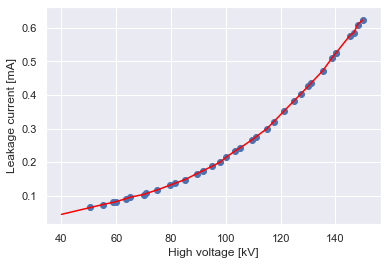

In [35]:
# interpolate
X = data_leak['HV_voltage'].values.astype(np.float64)
Y = data_leak['HV_current'].values.astype(np.float64)
interp_leak = interp1d(X, Y, fill_value='extrapolate')
x = np.linspace(40, 160, 1000, endpoint=True)
plt.plot(x, interp_leak(x), color='red')
plt.scatter(data_leak['HV_voltage'], data_leak['HV_current'])
plt.xlabel('High voltage [kV]')
plt.ylabel('Leakage current [mA]')
plt.show()

In [36]:
# real target current without leakage current
data['HV_current_real'] = data['HV_current_m'] - interp_leak(data['HV_voltage_m'].values)

In [37]:
# gauss fehler
data['power'] = data['HV_current_real'] * data['HV_voltage_m']
# np.sqrt((I * dI)**2+(V * dV)**2)
data['power_std'] = np.sqrt((data['HV_voltage_m'] * data['HV_current_std'])**2 + (data['HV_current_real'] * data['HV_voltage_std'])**2)
data

,t0,t1,tdiff,HV_voltage_m,HV_current_m,HV_voltage_std,HV_current_std,dose_corrected_m,dose_corrected_std,HV_current_real,power,power_std
0,2020-02-03 08:29:10,2020-02-03 08:31:50,160,50.908239,0.481293,1.647150e+00,2.096023e-01,0.015074,0.076118,0.415800,21.167662,1.069244e+01
1,2020-02-03 08:32:10,2020-02-03 08:36:50,280,55.000000,0.604682,0.000000e+00,4.184416e-03,0.000000,0.000000,0.531169,29.214292,2.301429e-01
2,2020-02-03 08:37:10,2020-02-03 08:37:50,40,55.970590,0.606720,1.837000e+00,6.541070e-03,0.000000,0.000000,0.531693,29.759169,1.043080e+00
3,2020-02-03 08:38:10,2020-02-03 08:43:50,340,59.983517,0.549742,6.764678e-02,1.683081e-01,30.795268,19.558481,0.467549,28.045209,1.009576e+01
4,2020-02-03 08:44:10,2020-02-03 08:45:50,100,61.461676,0.621822,2.234345e+00,8.077648e-03,52.933022,17.594489,0.536017,32.944506,1.296471e+00
5,2020-02-03 08:46:10,2020-02-03 08:49:50,220,65.000000,0.634000,0.000000e+00,9.992007e-16,135.267851,12.869774,0.538865,35.026218,6.494805e-14
6,2020-02-03 08:50:10,2020-02-03 08:54:50,280,69.066980,0.647578,1.929823e+00,6.642891e-03,167.451323,21.072872,0.545760,37.694007,1.148815e+00
7,2020-02-03 08:55:10,2020-02-03 08:57:50,160,70.000000,0.647255,0.000000e+00,4.903660e-04,185.943660,5.904603,0.543904,38.073266,3.432562e-02
8,2020-02-03 08:58:10,2020-02-03 08:59:50,100,71.906065,0.653140,2.327349e+00,7.372462e-03,199.709090,22.234194,0.544256,39.135307,1.373133e+00
9,2020-02-03 09:00:10,2020-02-03 09:04:50,280,74.848500,0.662024,4.263256e-14,2.123359e-03,255.211692,5.481025,0.545267,40.812445,1.589302e-01


### Dose to neutron output

In [52]:
data_mcnp_LUT = pd.read_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv", index_col=0) # output per 100 muSv/hr
# take 100 kV
dose_to_output = data_mcnp_LUT.loc[100, 'E']
dose_to_output = dose_to_output / 100 # per 1 muSv/h
dose_to_output # output per 1 muSv/hr

3471954.1960762125

In [53]:


data['neutron_output'] = data['dose_corrected_m'] * dose_to_output
data['neutron_output_std'] = data['dose_corrected_std'] * dose_to_output

data['ratio'] = (data['neutron_output'] / data['power']) * 1e-5
data['ratio_std'] = np.sqrt( ( ( ( data['neutron_output_std'] ) / data['power'])**2 ) + ( ( ( data['neutron_output'] ) / ( (data['power'])**2 ) * data['power_std'] )**2 ) ) * 1e-5
cols = ['power', 'power_std', 'neutron_output', 'neutron_output_std', 'ratio', 'ratio_std']
data[cols]

,power,power_std,neutron_output,neutron_output_std,ratio,ratio_std
0,21.167662,1.069244e+01,5.233467e+02,2.642771e+03,0.000247,0.001255
1,29.214292,2.301429e-01,0.000000e+00,0.000000e+00,0.000000,0.000000
2,29.759169,1.043080e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3,28.045209,1.009576e+01,1.069198e+06,6.790615e+05,0.381241,0.278320
4,32.944506,1.296471e+00,1.837810e+06,6.108726e+05,0.557850,0.186720
5,35.026218,6.494805e-14,4.696438e+06,4.468327e+05,1.340835,0.127571
6,37.694007,1.148815e+00,5.813833e+06,7.316405e+05,1.542376,0.199711
7,38.073266,3.432562e-02,6.455879e+06,2.050051e+05,1.695646,0.053867
8,39.135307,1.373133e+00,6.933808e+06,7.719610e+05,1.771753,0.206818
9,40.812445,1.589302e-01,8.860833e+06,1.902987e+05,2.171111,0.047388


In [54]:
data.head()

,t0,t1,tdiff,HV_voltage_m,HV_current_m,HV_voltage_std,HV_current_std,dose_corrected_m,dose_corrected_std,HV_current_real,power,power_std,neutron_output,neutron_output_std,ratio,ratio_std
0,2020-02-03 08:29:10,2020-02-03 08:31:50,160,50.908239,0.481293,1.647150,0.209602,0.015074,0.076118,0.415800,21.167662,10.692442,5.233467e+02,2642.771056,0.000247,0.001255
1,2020-02-03 08:32:10,2020-02-03 08:36:50,280,55.000000,0.604682,0.000000,0.004184,0.000000,0.000000,0.531169,29.214292,0.230143,0.000000e+00,0.000000,0.000000,0.000000
2,2020-02-03 08:37:10,2020-02-03 08:37:50,40,55.970590,0.606720,1.837000,0.006541,0.000000,0.000000,0.531693,29.759169,1.043080,0.000000e+00,0.000000,0.000000,0.000000
3,2020-02-03 08:38:10,2020-02-03 08:43:50,340,59.983517,0.549742,0.067647,0.168308,30.795268,19.558481,0.467549,28.045209,10.095760,1.069198e+06,679061.497211,0.381241,0.278320
4,2020-02-03 08:44:10,2020-02-03 08:45:50,100,61.461676,0.621822,2.234345,0.008078,52.933022,17.594489,0.536017,32.944506,1.296471,1.837810e+06,610872.601069,0.557850,0.186720


### Clean some datapoints with very large errors --> low stability with many breakdowns

In [55]:
idx_to_remove = data[cols].loc[(data['power_std'] > 9) | (data['ratio_std'] > 2)].index
data_cleaned = data.drop(idx_to_remove)

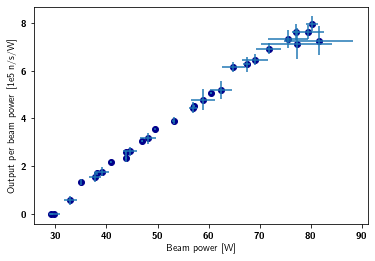

In [56]:
X = data_cleaned['power'].values # W
X_err = data_cleaned['power_std'].values # W
Y = data_cleaned['ratio'].values # 1e5 n/s/W
Y_err = data_cleaned['ratio_std'].values # 1e5 n/s/W
plt.scatter(X, Y, color='darkblue')
plt.errorbar(X, Y, yerr=Y_err, xerr=X_err, ls='none')
plt.ylabel('Output per beam power [1e5 n/s/W]')
plt.xlabel('Beam power [W]')
plt.show()

# Comparison with rotating target and robert data

- Roberts datafiles in: /Users/hkromer/02_PhD/02_Data/07.neutron_output/data_from_Robert/

In [57]:
from matplotlib.ticker import AutoMinorLocator
sns.reset_orig()
import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


### Roberts data

In [58]:
# output (neutrons/s)
output_data_file = '/Users/hkromer/02_PhD/02_Data/07.neutron_output/data_from_Robert/output_neutronsPerSecond.csv'
output_data = pd.read_csv(output_data_file)
# output per unit power (neutrons/s/W)
output_vs_power_file = '/Users/hkromer/02_PhD/02_Data/07.neutron_output/data_from_Robert/output_vs_power_neutronsPerSecondPerWatt.csv'
output_vs_power = pd.read_csv(output_vs_power_file)
#hv=60:5:125; % high voltage values in kV
hv = np.arange(60, 130, 5)
power = output_data / output_vs_power # beam power in W
neutron_yield_file = '/Users/hkromer/02_PhD/02_Data/07.neutron_output/data_from_Robert/output_vs_power.csv'
neutron_yield = pd.read_csv(neutron_yield_file, delimiter='\t')
neutron_yield = neutron_yield.multiply(1e5)

In [59]:
output_vs_power.head()

,3perc,6perc,9perc,12perc
0,47600,70800,80700,59700
1,59900,89300,101000,76800
2,74000,106000,107000,117000
3,84700,130000,112000,131000
4,105000,135000,123000,121000


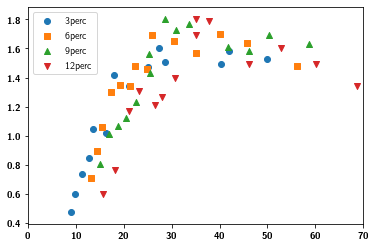

In [60]:
cols = power.columns.tolist()
markers = ['o', 's', "^", "v"]
for col, marker in zip(cols, markers):
    plt.scatter(power.loc[:,col], output_vs_power.loc[:,col]/1e5, marker=marker, label=col)

plt.xlim(0, 70)
plt.legend(loc='best')


### Rotating target data

In [61]:
# datafile from COMSOL
path_to_data = '/Users/hkromer/polybox/Thesis/Chapters/RotatingIonBeamTarget/Figures/neutron_yield_vs_beam_power/data/'
output_folder = '/Users/hkromer/polybox/Thesis/Chapters/RotatingIonBeamTarget/Figures/neutron_yield_vs_beam_power/'

df = pd.read_csv(f'{path_to_data}/df.csv', index_col=0)

In [62]:
OUTPUT_FOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Output_vs_beampower/'
FIGNAME = 'Output_vs_beampower'

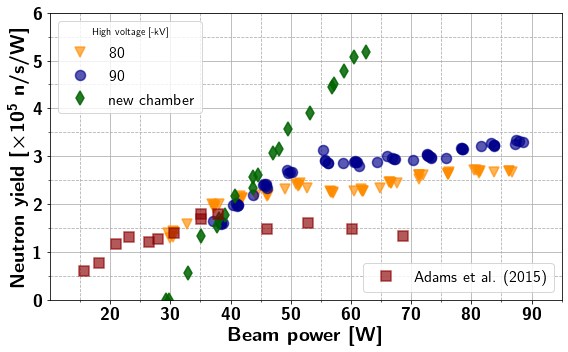

In [65]:
# -------------------------------------------------------------------
# plot measured output (n/s/W) vs beam power
# -------------------------------------------------------------------

fig = plt.figure(figsize=(8, 5))
fs = 20
ms = 10 # marker size
# axis 1
ax1 = fig.add_subplot(1, 1, 1)
# Hide the right and top spines
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)

# take only reasonable data
df1 = df[ ((df.index >= "2017-12-21 14:03") & (df.index <= "2017-12-21 15:06"))]
df2 = df[((df.index >= "2017-12-21 15:15") & (df.index <= "2017-12-21 16:14"))]
# print(df2.head())

ax1.plot(df1['beam_power'], (df1['output'] / df1['beam_power']) / 1e5,  'v',color="darkorange", markersize=ms, label='80', alpha=0.65, markeredgewidth=1.5, markeredgecolor='darkorange')
ax1.plot(df2['beam_power'], (df2['output'] / df2['beam_power']) / 1e5,  'o',color="darkblue", markersize=ms, label = '90', alpha=0.65, markeredgewidth=1.5, markeredgecolor='darkblue')
ax1.plot(X, Y, 'd', color='darkgreen', markersize=ms, label = 'new chamber', alpha=0.85, markeredgewidth=1.5, markeredgecolor='darkgreen')
plt.ylim(0,6)
plt.xlim(10,95)
ax1.xaxis.set_ticks(np.arange(20,100,10))
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
# tick font size
ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	
ax1.set_ylabel(r'\textbf{Neutron yield [$\times 10^5$ n/s/W]}', fontsize=fs)
ax1.set_xlabel(r'\textbf{Beam power [W]}', fontsize=fs, labelpad=2)

# ax1.text(70, 1e7, r"Data averaged over 1 min"  "\n"  r"ca 250 rpm" "\n" r"0.4 - 1.0 mA (DF 1 - 60 \% )",  bbox={'facecolor':'white', 'alpha':0.9, 'pad':10})

ax1.grid(b=True, which='major', linestyle='-')#, color='gray')
ax1.grid(b=True, which='minor', linestyle='--')#, color='gray')
leg1 = plt.legend(loc="upper left",  fontsize=fs-4)
leg1.set_title(r"High voltage [-kV]", prop = {'size': 10})

col = '12perc'
marker = 's'
plot_adams, = ax1.plot(power.loc[:,col], output_vs_power.loc[:,col]/1e5, color='darkred', linestyle='None', markeredgecolor='darkred', markersize=ms, alpha=0.65, markeredgewidth=1.5, marker=marker)
leg2 = ax1.legend([plot_adams],['Adams et al. (2015)'], loc='lower right', fontsize=fs-4)
# Manually add the first legend back
ax1.add_artist(leg1)
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf', dpi=900)
plt.show()
